# Plot the astrometric signatures of known exoplanet host stars 

In this notebook we query two exoplanet catalogs and estimate the expected amplitude (semi-major axis) of the host star's Keplerian motion caused by the orbiting planet.

Dependencies:
    astropy, pandas, astroquery, pystrometry

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import glob
import os
import pprint 

import astropy.constants as constants
from astropy.table import Table, vstack
import astropy.units as u
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
from astroquery.exoplanet_orbit_database import ExoplanetOrbitDatabase
from IPython.display import display
import matplotlib as mp
import matplotlib.pylab as pl
import numpy as np
import pandas as pd

from pystrometry.pystrometry import semimajor_axis_barycentre_angular

In [3]:
LOCAL_PATH = os.path.dirname(os.getcwd())
TEMPORARY_DIR = os.path.join(LOCAL_PATH, 'temp')
if os.path.isdir(TEMPORARY_DIR) is False:
    os.makedirs(TEMPORARY_DIR)
print(LOCAL_PATH)

/Users/jsahlmann/code/github/JohannesSahlmann/pystrometry


In [4]:
pp = pprint.PrettyPrinter(indent=4)     
%matplotlib inline
mp.rcParams['figure.figsize'] = (18, 9)
mp.rcParams['font.size'] = 20
mp.rcParams['ytick.direction'] = 'in'
mp.rcParams['xtick.direction'] = 'in'

In [5]:
save_plot = True

### Some useful functions

https://exoplanetarchive.ipac.caltech.edu/docs/program_interfaces.html

In [6]:
def get_exoplanets(selected_table_name, overwrite=False):
    
    local_data_file_name = {'eod': 'exoplanet_orbit_database_table.ecsv',
                           'nasa': 'nasa_exoplanet_archive_table.ecsv'}

    eod_file = os.path.join(TEMPORARY_DIR, local_data_file_name[selected_table_name])

    if not os.path.isfile(eod_file) or overwrite:
        if selected_table_name == 'eod':
            table = ExoplanetOrbitDatabase.get_table()
        elif selected_table_name == 'nasa':
            # https://exoplanetarchive.ipac.caltech.edu/docs/program_interfaces.html
            table = NasaExoplanetArchive.query_criteria(table="exoplanets", select="*", cache=True)
            #         table = NasaExoplanetArchive.query_criteria(table="cumulative", select="*", cache=True)
            #         table_kepler = NasaExoplanetArchive.query_criteria(table="cumulative", select="*", cache=True)

        table.write(eod_file, overwrite=True)

    table = Table.read(eod_file)
    return table


parameter_mapping_all = {'eod': {'period': 'PER',
                     'ecc': 'ECC',
                     'm2': 'MASS',
                     'omega': 'OM',
                     'plx': 'PAR',
                     'star_mass': 'MSTAR',
                     'distance_pc': 'DIST'
                     },
                     'nasa':{'period': 'pl_orbper',         # https://exoplanetarchive.ipac.caltech.edu/docs/API_exoplanet_columns.html
                             'm2': 'pl_bmassj',
                             'plx': 'gaia_plx',
                             'star_mass': 'st_mass',
                             'distance_pc': 'st_dist'
                             }}


def set_astrometric_observables(table, selected_table_name):
    """Compute photocentre orbit size and other parameters."""

    parameter_mapping = parameter_mapping_all[selected_table_name]                     

    planet_mass_mj = table[parameter_mapping['m2']]
    parallax_mas = table[parameter_mapping['plx']]
    period_day = table[parameter_mapping['period']]
    star_mass_msun = table[parameter_mapping['star_mass']]

    table['a_phot_mas'] = semimajor_axis_barycentre_angular(star_mass_msun, planet_mass_mj, period_day, parallax_mas)
    table['period_year'] = (table[parameter_mapping['period']].to(u.year))
    table['a_phot_muas'] = table['a_phot_mas']*1000

    table['log10_distance_pc'] = np.log10(table[parameter_mapping['distance_pc']])
    
    return table

def set_a_phot_mas(table, selected_table_name):
    """Compute photocentre orbit size (works on pandas dataframe)."""

    parameter_mapping = parameter_mapping_all[selected_table_name]                     

    planet_mass_mj = table[parameter_mapping['m2']]
    parallax_mas = table[parameter_mapping['plx']]
    period_day = table[parameter_mapping['period']]
    star_mass_msun = table[parameter_mapping['star_mass']]

    table['a_phot_mas'] = semimajor_axis_barycentre_angular(star_mass_msun, planet_mass_mj, period_day, parallax_mas)
    table['a_phot_muas'] = table['a_phot_mas']*1000
    
    return table

### Get table from NasaExoplanetArchive

In [7]:
selected_table_name = 'nasa'  
table = get_exoplanets(selected_table_name) 
table = set_astrometric_observables(table, selected_table_name)

/Users/jsahlmann/code/github/JohannesSahlmann/pystrometry/pystrometry/pystrometry.py:4078: RuntimeWarning: invalid value encountered in true_divide
  M = (Ggrav * (m2_MJ * MJ_kg)**3.
/Users/jsahlmann/code/github/JohannesSahlmann/pystrometry/pystrometry/pystrometry.py:4048: RuntimeWarning: divide by zero encountered in true_divide
  d_pc  = 1. / (plx_mas / 1000.)
/tmp/ipykernel_3510/3769182680.py:53: RuntimeWarning: divide by zero encountered in log10
  table['log10_distance_pc'] = np.log10(table[parameter_mapping['distance_pc']])


### Get table from ExoplanetOrbitDatabase for KOIs

In [8]:
eod_table = get_exoplanets('eod')  
eod_table = set_astrometric_observables(eod_table, 'eod')

eod_df = eod_table.to_pandas()
eod_df_koi = eod_df[eod_df['EANAME'].str.contains('Kepler').fillna(False)]

/tmp/ipykernel_3510/3769182680.py:53: RuntimeWarning: divide by zero encountered in log10
  table['log10_distance_pc'] = np.log10(table[parameter_mapping['distance_pc']])


## Solar system planets  at 10 pc     
http://www.windows2universe.org/our_solar_system/planets_table.html

In [9]:
solar_system = pd.DataFrame()

solar_system['period_year'] = [0.24 ,0.62, 1, 1.88, 11.86, 29.46, 84.01, 164.8]
solar_system['period_day'] = solar_system['period_year'] * u.year.to(u.day)
solar_system['planet_mass_mj'] = np.array([0.055,0.815, 1, 0.107, 318, 95, 15, 17]) * u.M_earth.to(u.M_jup)
solar_system['distance_pc'] = 10
solar_system['parallax_mas'] = 1e3/solar_system['distance_pc']
solar_system['planet_name'] = ['Me','V','E','Ma','J','S','U','N']
solar_system['star_mass_msun'] = 1

solar_system['a_phot_mas'] = semimajor_axis_barycentre_angular(solar_system['star_mass_msun'], solar_system['planet_mass_mj'], solar_system['period_day'], solar_system['parallax_mas'])
solar_system['a_phot_muas'] = solar_system['a_phot_mas']*1e3

display(solar_system)

,period_year,period_day,planet_mass_mj,distance_pc,parallax_mas,planet_name,star_mass_msun,a_phot_mas,a_phot_muas
0,0.24,87.6600,0.000173,10,100.0,Me,1,0.000006,0.006380
1,0.62,226.4550,0.002564,10,100.0,V,1,0.000178,0.177980
2,1.00,365.2500,0.003146,10,100.0,E,1,0.000300,0.300345
3,1.88,686.6700,0.000337,10,100.0,Ma,1,0.000049,0.048953
4,11.86,4331.8650,1.000540,10,100.0,J,1,0.496395,496.395467
5,29.46,10760.2650,0.298903,10,100.0,S,1,0.272114,272.113525
6,84.01,30684.6525,0.047195,10,100.0,U,1,0.086414,86.414409
7,164.80,60193.2000,0.053488,10,100.0,N,1,0.153471,153.470970


## Individual systems (mostly Gaia-HIP accelerations)

In [10]:
individuals = pd.DataFrame()

individuals['planet_name'] = ['HD 33632 Ab', 'Proxima c', 'HD 113337 c', 'HD 38529 c', 'pi Men b', 'beta Pic b', 'eps indi A b']
individuals['ref'] = ['Currie+20', 'Kervella+20', 'Xuan+20', 'Xuan+20', 'De Rosa+20', 'Brandt+20', 'Feng+19']

individuals['period_year'] = np.array([91* u.year.to(u.day), 1900, 3165, 2135, 2089.11, 8880, 45.2*u.year.to(u.day)])* u.day.to(u.year)
individuals['period_day'] = individuals['period_year'] * u.year.to(u.day)
individuals['planet_mass_mj'] = np.array([46, 12* u.M_earth.to(u.M_jup), 14, 18, 13.01, 9.8, 3.25]) 
individuals['distance_pc'] = [26.56, 1000./768.5, 1000./27.64, 1000./23.611, 1000/ 54.7052, 1000./50.58, 1000./274.8]
individuals['parallax_mas'] = 1e3/individuals['distance_pc']
individuals['star_mass_msun'] = [1.108, 0.122, 1.40, 1.36, 1.094, 1.83, 0.754]

individuals['a_phot_mas'] = semimajor_axis_barycentre_angular(individuals['star_mass_msun'], individuals['planet_mass_mj'], individuals['period_day'], individuals['parallax_mas'])
individuals['a_phot_muas'] = individuals['a_phot_mas']*1e3

## HIP-Gaia systems from Li+21: Precise Masses and Orbits for Nine Radial Velocity Exoplanets 
#### https://ui.adsabs.harvard.edu/abs/2021arXiv210910422L


In [11]:

planet_name = '''HD~29021~b 
HD~81040~b 
HD~87883~b   
HD~98649~b 
HD~106252~b
HD~106515~Ab
HD~106515~B
HD~171238~b 
HD~196067~b  
HD~196068
HD~221420~b'''
planet_name = planet_name.split('\n')
planet_name = [s.replace(' ','').replace('~', ' ') for s in planet_name]

m1_ms = '''0.86
0.97
0.80
0.97
1.05
0.90
0.90
0.92
1.34
1.34
1.30'''.split('\n')

planet_mass_mj = '''4.47
7.24
6.31
9.7
10.0
18.9
904
8.8
12.5
1235
20.6'''.split('\n')

period_year = '''3.737
2.7452
8.23
14.74
4.202
9.927
4630
4.148
9.88
44300
27.7'''.split('\n')

parallax_mas = '''32.385
29.063
54.668
23.721
26.248
29.315
29.391
22.481
25.033
25.038
32.102'''.split('\n')

li21 = pd.DataFrame()
li21['planet_name'] = planet_name
li21['star_mass_msun'] = np.array(m1_ms).astype(float)
li21['planet_mass_mj'] = np.array(planet_mass_mj).astype(float)
li21['parallax_mas'] = np.array(parallax_mas).astype(float)
li21['distance_pc'] = 1000./li21['parallax_mas']
li21['ref'] = 'Li+21'
li21['period_year'] = np.array(period_year).astype(float)
li21['period_day'] = li21['period_year']*u.year.to(u.day)

li21['a_phot_mas'] = semimajor_axis_barycentre_angular(li21['star_mass_msun'], li21['planet_mass_mj'], li21['period_day'], li21['parallax_mas'])
li21['a_phot_muas'] = li21['a_phot_mas']*1e3

li21 = li21[li21['planet_mass_mj']<100]
# display(li21)
individuals = pd.concat((individuals, li21))

## One system from Feng+21: Optimized modelling of Gaia-Hipparcos astrometry for the detection of the smallest cold Jupiter and confirmation of seven low-mass companions 
https://ui.adsabs.harvard.edu/abs/2021MNRAS.507.2856F/abstract

In [12]:
feng21 = pd.DataFrame({'planet_name': 'HD 190360 b', 'ref': 'Feng+21', 'period_year': 7.815, 'planet_mass_mj': 1.8, 'parallax_mas': 62.49, 'star_mass_msun': 1.0}, index=[0])
feng21['period_day'] = feng21['period_year']*u.year.to(u.day)

feng21['a_phot_mas'] = semimajor_axis_barycentre_angular(feng21['star_mass_msun'], feng21['planet_mass_mj'], feng21['period_day'], feng21['parallax_mas'])
feng21['a_phot_muas'] = feng21['a_phot_mas']*1e3
feng21['distance_pc'] = 1000./feng21['parallax_mas']
individuals = pd.concat((individuals, feng21))
individuals.reset_index(inplace=True)

In [13]:
# individuals.columns

In [14]:
display(individuals)

,index,planet_name,ref,period_year,period_day,planet_mass_mj,distance_pc,parallax_mas,star_mass_msun,a_phot_mas,a_phot_muas
0,0,HD 33632 Ab,Currie+20,91.000000,33237.75000,46.000000,26.560000,37.650602,1.108,30.438599,30438.599047
1,1,Proxima c,Kervella+20,5.201916,1900.00000,0.037756,1.301236,768.500000,0.122,0.337984,337.983829
2,2,HD 113337 c,Xuan+20,8.665298,3165.00000,14.000000,36.179450,27.640000,1.400,1.237368,1237.368314
3,3,HD 38529 c,Xuan+20,5.845311,2135.00000,18.000000,42.353140,23.611000,1.360,1.063517,1063.516641
4,4,pi Men b,De Rosa+20,5.719671,2089.11000,13.010000,18.279798,54.705200,1.094,2.031204,2031.203704
5,5,beta Pic b,Brandt+20,24.312115,8880.00000,9.800000,19.770660,50.580000,1.830,2.645187,2645.186869
6,6,eps indi A b,Feng+19,45.200000,16509.30000,3.250000,3.639010,274.800000,0.754,13.022748,13022.747616
7,0,HD 29021 b,Li+21,3.737000,1364.93925,4.470000,30.878493,32.385000,0.860,0.366760,366.759633
8,1,HD 81040 b,Li+21,2.745200,1002.68430,7.240000,34.408010,29.063000,0.970,0.399980,399.979988
9,2,HD 87883 b,Li+21,8.230000,3006.00750,6.310000,18.292237,54.668000,0.800,1.549806,1549.805893


In [15]:
# # eps Eri b   Llop-Sayson+21
# # (Mawet+17 ignores the HST astrometry)
# individual_system = df[df['pl_name'].str.contains('eps Eri b').fillna(False)].copy().reset_index()
# individual_system.loc[0,'pl_bmassj'] = [0.66]
# individual_system['ref'] = 'Llop-Sayson+21'


# individuals = pd.concat([individuals, individual_system[individuals.columns]])
# individuals

In [16]:
print(individuals[['planet_name', 'ref']].to_csv(index=False, sep=';'))

planet_name;ref
HD 33632 Ab;Currie+20
Proxima c;Kervella+20
HD 113337 c;Xuan+20
HD 38529 c;Xuan+20
pi Men b;De Rosa+20
beta Pic b;Brandt+20
eps indi A b;Feng+19
HD 29021 b;Li+21
HD 81040 b;Li+21
HD 87883 b;Li+21
HD 98649 b;Li+21
HD 106252 b;Li+21
HD 106515 Ab;Li+21
HD 171238 b;Li+21
HD 196067 b;Li+21
HD 221420 b;Li+21
HD 190360 b;Feng+21



## Systems with fully measured photocentre orbits

In [17]:
df = table.to_pandas()

# ups And c,d
selected_systems = df[df['hip_name'].str.contains('HIP 7513').fillna(False)].iloc[[1,2]]
selected_systems['pl_bmassj'] = [13.98, 10.25]
selected_systems['ref'] = 'McArthur+10'

#  HD 38529 c
individual_system = df[df['pl_name'].str.contains('HD 38529 c').fillna(False)].copy().reset_index()
individual_system.loc[0, 'pl_bmassj'] = [17.6]
individual_system['ref'] = 'Benedict+10'
selected_systems = pd.concat([selected_systems, individual_system])

#  HD 128311 b
individual_system = df[df['pl_name'].str.contains('HD 128311 b').fillna(False)].copy().reset_index()
individual_system.loc[0, 'pl_bmassj'] = [3.789]
individual_system['ref'] = 'McArthur+14'
selected_systems = pd.concat([selected_systems, individual_system])

#  HD 202206 c
individual_system = df[df['pl_name'].str.contains('HD 202206 c').fillna(False)].copy().reset_index()
individual_system.loc[0, 'ref'] = 'Benedict+17'
selected_systems = pd.concat([selected_systems, individual_system])


#  GJ 676A b
individual_system = df[df['pl_name'].str.contains('GJ 676 A b').fillna(False)].copy().reset_index()
individual_system.loc[0, 'pl_bmassj'] = [6.7]
individual_system['ref'] = 'Sahlmann+16'
selected_systems = pd.concat([selected_systems, individual_system])

selected_systems = set_a_phot_mas(selected_systems, 'nasa')

individual_system = pd.DataFrame()
individual_system['pl_name'] = ['TVLM 513–46546 b']
individual_system['pl_bmassj'] = [0.38]
individual_system['a_phot_mas'] = [0.128]
individual_system['ref'] = ['Curiel+20']
individual_system['period_year'] = [220./u.year.to(u.day)]
individual_system['distance_pc'] = [1000./93.405]

individual_system['a_phot_muas'] = individual_system['a_phot_mas']*1000
individual_system['st_dist'] = individual_system['distance_pc']

selected_systems = pd.concat([selected_systems, individual_system])
selected_systems.reset_index(inplace=True)
display(selected_systems[['pl_name', 'period_year', 'pl_bmassj', 'a_phot_muas', 'ref', 'pl_def_refname']])

,pl_name,period_year,pl_bmassj,a_phot_muas,ref,pl_def_refname
0,ups And c,0.660528,13.980,629.351182,McArthur+10,Curiel et al. 2011
1,ups And d,3.494757,10.250,1403.608812,McArthur+10,Curiel et al. 2011
2,HD 38529 c,5.848323,17.600,1014.647375,Benedict+10,Luhn et al. 2019
3,HD 128311 b,1.240298,3.789,288.536056,McArthur+14,McArthur et al. 2014
4,HD 202206 c,3.449692,17.900,716.430919,Benedict+17,Benedict &amp; Harrison 2017
5,GJ 676 A b,2.893361,6.700,993.248896,Sahlmann+16,Stassun et al. 2017
6,TVLM 513–46546 b,0.602327,0.380,128.000000,Curiel+20,NaN


In [18]:
print(selected_systems[['pl_name', 'ref']].to_csv(index=False, sep=','))

pl_name,ref
ups And c,McArthur+10
ups And d,McArthur+10
HD 38529 c,Benedict+10
HD 128311 b,McArthur+14
HD 202206 c,Benedict+17
GJ 676 A b,Sahlmann+16
TVLM 513–46546 b,Curiel+20



## Generate figure

/tmp/ipykernel_3510/443072314.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eod_df_koi.sort_values('DIST', inplace=True, ascending=True)


'/Users/jsahlmann/code/github/JohannesSahlmann/pystrometry/temp/nasa_True_True_astrometry_signatures.png'

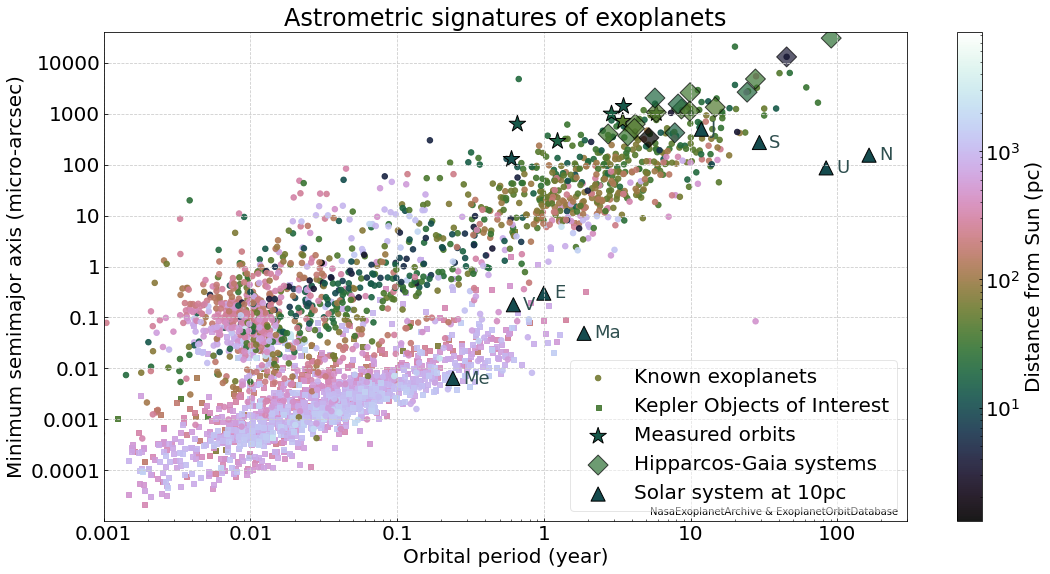

In [23]:
include_koi = True
include_individuals = True
include_orbits = True
include_solar_system = True

# make the KOI symbol visible in the legend
eod_df_koi['DIST'].replace(0, np.nan, inplace=True)
eod_df_koi.sort_values('DIST', inplace=True, ascending=True)

def annotate_df(row):  
    #     https://stackoverflow.com/questions/15910019/annotate-data-points-while-plotting-from-pandas-dataframe
    ax.annotate(row.planet_name, (row.period_year, row.a_phot_muas),
                xytext=(10,-5), 
                textcoords='offset points',
                size=18, 
                color='darkslategrey')
    

x = 'period_year' 
y = 'a_phot_muas'

if y == 'a_phot_muas':
    factor = 1000

colour_by = 'distance_pc'
norm = mp.colors.LogNorm()
colormap='viridis'
colormap='cubehelix'

fig, ax = pl.subplots()
df.plot(x, y, kind='scatter', logx=True, logy=True, c=parameter_mapping_all['nasa'][colour_by], norm=norm, colormap=colormap, s=30, alpha=0.9, ax=ax, zorder=1, label='Known exoplanets')
if include_koi:
    eod_df_koi.plot(x, y, kind='scatter', logx=True, logy=True, c=parameter_mapping_all['eod'][colour_by], colormap=colormap, s=25, marker='s', alpha=0.9, zorder=-50, norm=norm, ax=ax, colorbar=False, label='Kepler Objects of Interest')
pl.ylim((1e-8*factor, 40*factor))
pl.xlim((1e-3, 300))
if include_orbits:
    selected_systems.plot(x, y, kind='scatter', logx=True, logy=True, s=300, c=parameter_mapping_all['nasa'][colour_by], ax=ax, norm=norm, colormap=colormap, colorbar=False, label='Measured orbits',  marker='*', edgecolor='k') #,    
if include_individuals:
    individuals.plot(x, y, kind='scatter', logx=True, logy=True, s=200, c=colour_by, ax=ax, norm=norm, colormap=colormap, colorbar=False, label='Hipparcos-Gaia systems',  marker='D', edgecolor='k', alpha=0.7) #,
if include_solar_system:
    solar_system.plot(x, y, kind='scatter', logx=True, logy=True, s=200, c=colour_by, ax=ax, norm=norm, colormap=colormap, colorbar=False, marker='^', label='Solar system at 10pc', edgecolor='k')
    _ = solar_system.apply(annotate_df, axis=1)
pl.xlabel('Orbital period (year)')
pl.ylabel('Minimum semimajor axis (micro-arcsec)')
ax.grid(ls='--', color='0.8')
ax.set_zorder(-52)

xticks = [0.001, 0.01, 0.1, 1, 10, 100] 
xtick_labels = np.array(['0.001', '0.01', '0.1', '1', '10', '100'])
pl.xticks(xticks, xtick_labels)

yticks = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 1e4] 
ytick_labels = np.array(yticks).astype(str)
ytick_labels = np.array(['0.0001', '0.001', '0.01', '0.1', '1', '10', '100', '1000', '10000'])
pl.yticks(yticks, ytick_labels)

cax = fig.get_axes()[1]
cax.set_ylabel('Distance from Sun (pc)')
pl.legend(loc=4, framealpha=0.5)

pl.text(0.68, 0.03, 'NasaExoplanetArchive & ExoplanetOrbitDatabase', horizontalalignment='left', verticalalignment='top',
        transform=pl.gca().transAxes, fontsize=10)

pl.title('Astrometric signatures of exoplanets')
if save_plot:
    figure_file_name = os.path.join(TEMPORARY_DIR, '{}_{}_{}_astrometry_signatures.png'.format(selected_table_name, include_individuals, include_orbits))
    pl.savefig(figure_file_name, transparent=False, bbox_inches='tight', pad_inches=0.05)        
display(figure_file_name)    